<a href="https://colab.research.google.com/github/pchandrasekaran1595/NISTs/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d zalando-research/fashionmnist

!mkdir ~/.data
!unzip -q fashionmnist.zip -d /.data

Saving kaggle.json to kaggle.json
kaggle.json
 97% 67.0M/68.8M [00:03<00:00, 14.7MB/s]
100% 68.8M/68.8M [00:03<00:00, 18.6MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import os
import gc
import re
from time import time

seed = 42

In [3]:
def breaker():
    print("\n" + 50*"-" + "\n")

def head(x=None, no_of_ele=5):
    print(x[:no_of_ele])

# Data

In [4]:
tr_set = pd.read_csv("/.data/fashion-mnist_train.csv")
ts_set = pd.read_csv("/.data/fashion-mnist_test.csv")

breaker()
print("Train Set Shape : ", repr(tr_set.shape))
breaker()
print("Test Set Shape  : ", repr(ts_set.shape))
breaker()
print(tr_set.head(5))
breaker()
print(ts_set.head(5))
breaker()


--------------------------------------------------

Train Set Shape :  (60000, 785)

--------------------------------------------------

Test Set Shape  :  (10000, 785)

--------------------------------------------------

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]

--------------------------------------------------

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      0       0       0       0  ...         0         0         0         0
1      1       0       0       0  ...         0         0         0         

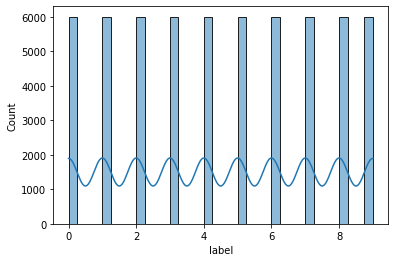

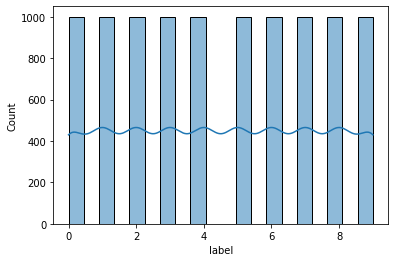

In [5]:
sns.histplot(data=tr_set, x="label", kde=True)
plt.show()

sns.histplot(data=ts_set, x="label", kde=True)
plt.show()

**Dataset Templates**

In [6]:
class Linear_DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.transform = transform
        this.X = X
        if mode == "train" or mode == "valid":
            this.y = y

    def __len__(this):
        return this.X.shape[0]

    def __getitem__(this, idx):
        if this.mode == "train" or this.mode == "valid":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

class CNN_DS(Dataset):
    def __init__(this, X=None, y=None, transform=None, mode="train"):
        this.mode = mode
        this.transform = transform
        this.X = X.reshape(X.shape[0], 1, 28, 28)/255
        if mode == "train" or mode == "valid":
            this.y = y

    def __len__(this):
        return this.X.shape[0]

    def __getitem__(this, idx):
        if this.mode == "train" or this.mode == "valid":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# Model Configuation and Setups

**Config**

In [7]:
class CFG():
    tr_batch_size = 128
    va_batch_size = 128
    ts_batch_size = 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    in_channels = 1
    OL = 10

    def __init__(this, filter_sizes=None, HL=None, AP_size=None, epochs=None, n_folds=None):
        this.filter_sizes = filter_sizes
        this.HL = HL
        this.AP_size = AP_size
        this.epochs = epochs
        this.n_folds = n_folds

**Models**

In [15]:
class CNN_6(nn.Module):
    def __init__(this, in_channels=None, filter_sizes=None, HL=None, OL=None, use_DP=False, DP=0.5):

        super(CNN_6, this).__init__()

        this.use_DP = use_DP
        if use_DP:
            this.DP_ = nn.Dropout(p=DP)

        this.MP_ = nn.MaxPool2d(kernel_size=2)
        
        this.CN1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)

        this.CN2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)

        this.CN3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)

        this.FC1 = nn.Linear(in_features=filter_sizes[2] * 3 * 3, out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=HL[1])
        this.FC3 = nn.Linear(in_features=HL[1], out_features=OL)

    def getOptimizer(this, A_S=True, lr=1e-3, wd=0):
        if A_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-6):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)
    
    def forward(this, x):
        if this.use_DP:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))

            x = x.view(x.shape[0], -1)

            x = F.relu(this.DP_(this.FC1(x)))
            x = F.relu(this.DP_(this.FC2(x)))
            x = F.log_softmax(this.FC3(x), dim=1)

            return x
        else:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))

            x = x.view(x.shape[0], -1)

            x = F.relu(this.FC1(x))
            x = F.relu(this.FC2(x))
            x = F.log_softmax(this.FC3(x), dim=1)

            return x

class CNN_7(nn.Module):
    def __init__(this, in_channels=None, filter_sizes=None, HL=None, OL=None, AP_size=None, use_DP=False, DP=0.5):

        super(CNN_7, this).__init__()

        this.use_DP = use_DP
        if use_DP:
            this.DP_ = nn.Dropout(p=DP)

        this.AP_ = nn.AdaptiveAvgPool2d(output_size=AP_size)
        this.MP_ = nn.MaxPool2d(kernel_size=2)
        
        this.CN1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)

        this.CN2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)

        this.CN3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)

        this.CN4 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.FC1 = nn.Linear(in_features=filter_sizes[3] * (AP_size**2), out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=HL[1])
        this.FC3 = nn.Linear(in_features=HL[1], out_features=OL)

    def getOptimizer(this, A_S=True, lr=1e-3, wd=0):
        if A_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-6):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)
    
    def forward(this, x):
        if this.use_DP:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))
            x = F.relu(this.MP_(this.BN4(this.CN4(x))))

            x = this.AP_(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(this.DP_(this.FC1(x)))
            x = F.relu(this.DP_(this.FC2(x)))
            x = F.log_softmax(this.FC3(x), dim=1)

            return x
        else:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))
            x = F.relu(this.MP_(this.BN4(this.CN4(x))))

            x = this.AP_(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(this.FC1(x))
            x = F.relu(this.FC2(x))
            x = F.log_softmax(this.FC3(x), dim=1)

            return x

**Helpers**

In [9]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None,
         trainloader=None, validloader=None, criterion=None, 
         device=None, verbose=False, checkpoint_freq=None, path=None):
    
    breaker()
    print("Training ...")
    breaker()

    if device:
        model.to(device)

    DLS = {"train" : trainloader, "valid" : validloader}
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    bestAccs = {"train" : 0.0, "valid" : 0.0}

    Losses = []
    Accuracies = []

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}
        epochAccs = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            lossPerPass = []
            accsPerPass = []

            for X, y in DLS[phase]:
                X, y = X.to(device), y.to(device).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = criterion(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(accuracy_score(torch.argmax(torch.exp(output), dim=1).detach().cpu().numpy(), y.detach().cpu().numpy()))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)

        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            bestLossEpoch = e+1
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            bestAccsEpoch = e+1

        if checkpoint_freq:
            if e % checkpoint_freq == 0:
                torch.save({"model_state_dict" : model.state_dict(),
                            "optimizer_state_dict" : optimizer.state_dict()},
                           "./Epoch_{}.pt".format(e+1))
        else:
            torch.save({"model_state_dict" : model.state_dict(),
                        "optimizer_state_dict" : optimizer.state_dict()},
                        "./Epoch_{}.pt".format(e+1))
            
        if scheduler:
            # scheduler.step(epochLoss["valid"])
            scheduler.step()
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | \
Train Accs: {:.5f} | Valid Accs: {:.5f} | Time : {:.2f} minutes".format(e+1, epochLoss["train"], epochLoss["valid"],
                                                                        epochAccs["train"], epochAccs["valid"],
                                                                        (time() - e_st)/60))
            
    breaker()
    print("-----> Best Validation Loss at Epoch {}".format(bestLossEpoch))
    breaker()
    print("-----> Best Validation Accs at Epoch {}".format(bestAccsEpoch))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return Losses, Accuracies, bestLossEpoch, bestAccsEpoch

def predict_(model=None, dataloader=None, device=None, path=None):
    if path:
        model.load_state_dict(torch.load(path)["model_state_dict"])
    
    model.to(device)
    model.eval()

    y_pred = torch.zeros(1, 1).to(device)

    for X, y in dataloader:
        X = X.to(device)
        with torch.no_grad():
            Pred = torch.argmax(torch.exp(model(X)), dim=1)
        y_pred = torch.cat((y_pred, Pred.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy().reshape(-1).astype(int)

# CNN 6

In [16]:
cfg = CFG(filter_sizes=[64, 128, 256, 512], HL=[4096, 4096], AP_size=3, epochs=15, n_folds=5)

BLE = []
BAE = []

LT = []
LV = []
AT = []
AV = []

tr_Set = tr_set.to_numpy()

fold = 0
breaker()
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_folds, shuffle=True, random_state=seed).split(tr_Set[:, 1:], tr_Set[:, 0]):
    print("PROCESSING FOLD {} ......".format(fold+1))

    tr_images, va_images, tr_labels, va_labels = tr_Set[tr_idx, 1:], tr_Set[va_idx, 1:], tr_Set[tr_idx, 0], tr_Set[va_idx, 0]

    tr_data_setup = CNN_DS(X=tr_images, y=tr_labels.reshape(-1, 1), transform=None, mode="train")
    va_data_setup = CNN_DS(X=va_images, y=va_labels.reshape(-1, 1), transform=None, mode="valid")

    tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(seed))
    va_data = DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)

    torch.manual_seed(seed)
    model = CNN_6(in_channels=cfg.in_channels, filter_sizes=cfg.filter_sizes, HL=cfg.HL, OL=cfg.OL, use_DP=True)
    optimizer = model.getOptimizer(lr=1e-3, wd=0)

    Losses, Accuracies, bestLossEpoch, bestAccsEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs,
                                                            trainloader=tr_data, validloader=va_data, criterion=nn.NLLLoss(), 
                                                            device=cfg.device, verbose=True, checkpoint_freq=1, path=None)
    
    BAE.append(bestAccsEpoch)
    BLE.append(bestLossEpoch)
    
    for i in range(len(Losses)):
        LT.append(Losses[i]["train"])
        LV.append(Losses[i]["valid"])
        AT.append(Accuracies[i]["train"])
        AV.append(Accuracies[i]["valid"])

    fold += 1 


--------------------------------------------------

PROCESSING FOLD 1 ......

--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 0.57570 | Valid Loss: 0.32561 | Train Accs: 0.80237 | Valid Accs: 0.88384 | Time : 0.20 minutes
Epoch: 2 | Train Loss: 0.32459 | Valid Loss: 0.28182 | Train Accs: 0.88369 | Valid Accs: 0.89666 | Time : 0.20 minutes
Epoch: 3 | Train Loss: 0.27075 | Valid Loss: 0.25104 | Train Accs: 0.90312 | Valid Accs: 0.91326 | Time : 0.20 minutes
Epoch: 4 | Train Loss: 0.23731 | Valid Loss: 0.23317 | Train Accs: 0.91485 | Valid Accs: 0.92024 | Time : 0.20 minutes
Epoch: 5 | Train Loss: 0.21346 | Valid Loss: 0.26319 | Train Accs: 0.92265 | Valid Accs: 0.90924 | Time : 0.20 minutes
Epoch: 6 | Train Loss: 0.19150 | Valid Loss: 0.23680 | Train Accs: 0.93156 | Valid Accs: 0.91808 | Time : 0.20 minutes
Epoch: 7 | Train Loss: 0.17247 | Valid Loss: 0.30857 | Train Accs: 0.93660 | Valid Accs: 

**Plots**

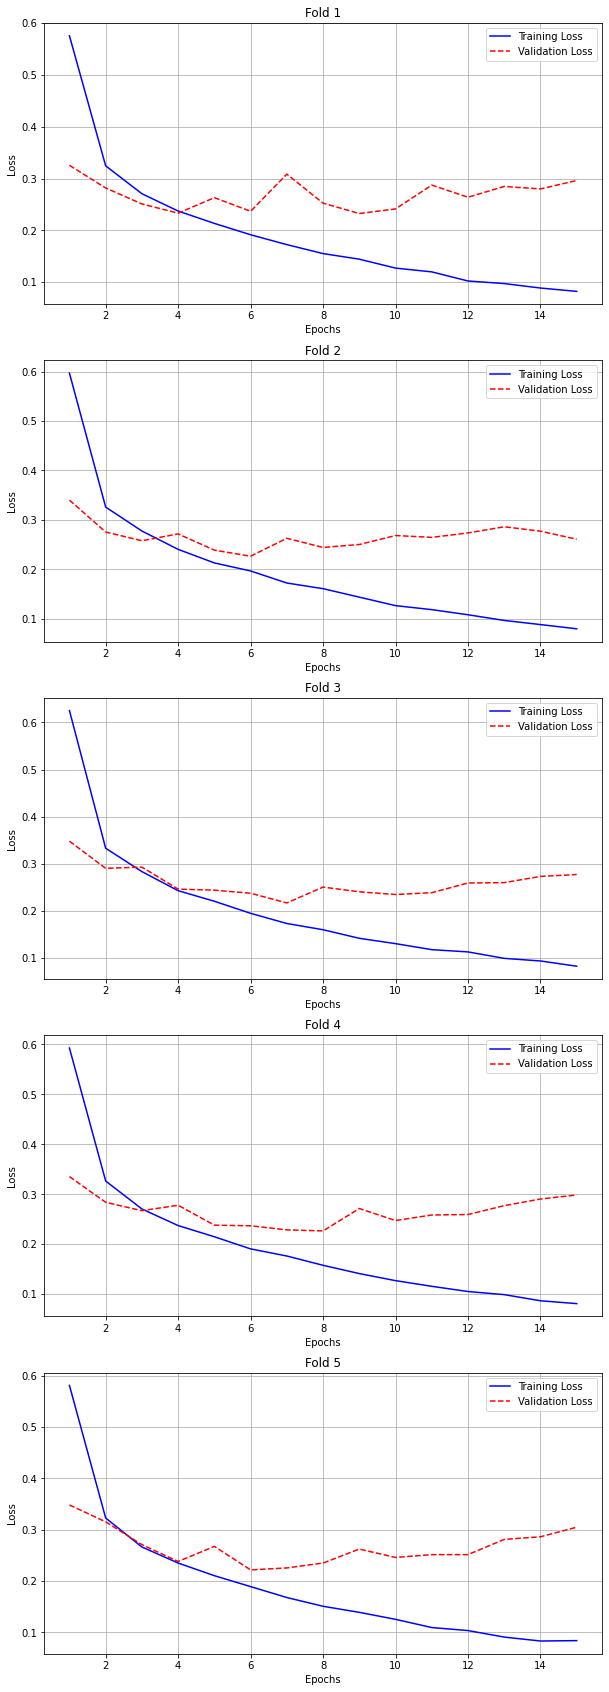

In [17]:
xAxis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

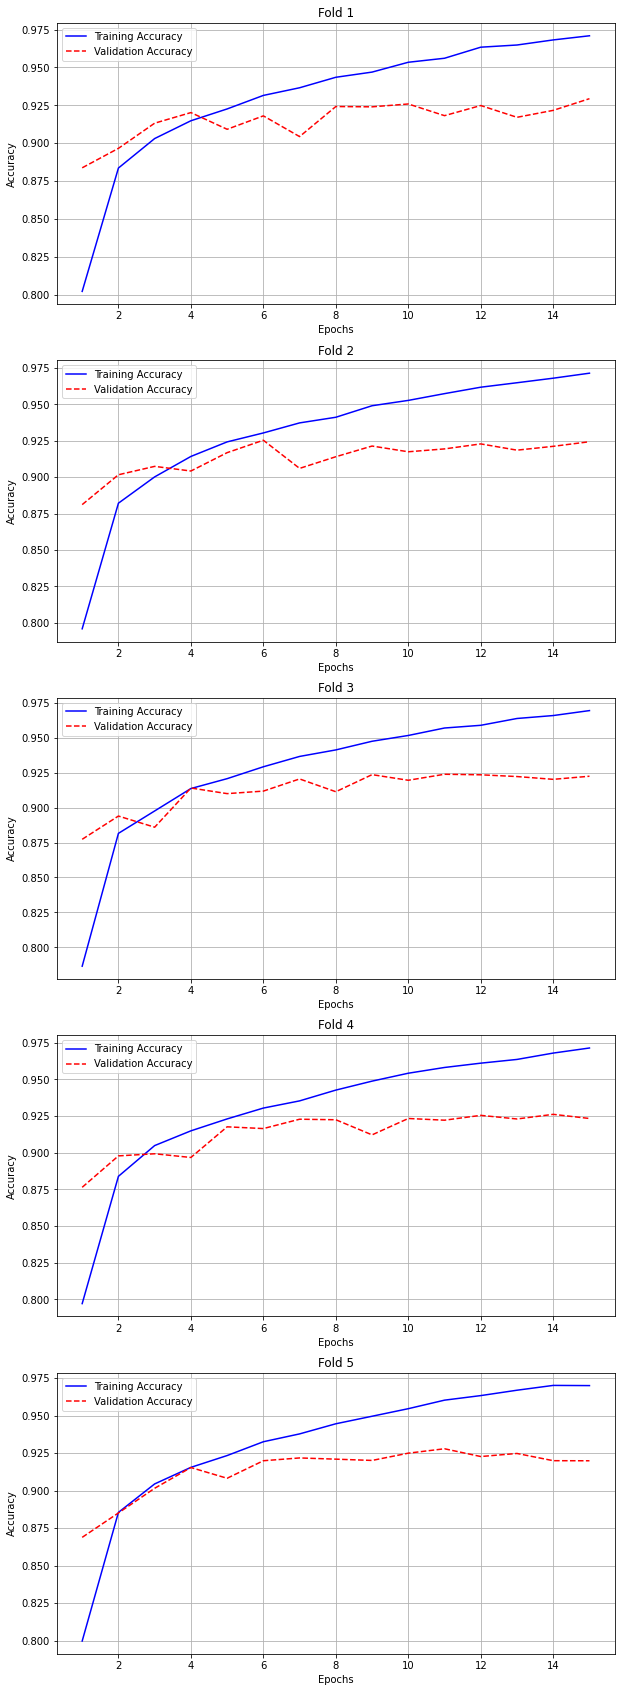

In [18]:
plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, AT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Accuracy")
    plt.plot(xAxis, AV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# CNN 7

**Training**

In [19]:
cfg = CFG(filter_sizes=[64, 128, 256, 512], HL=[4096, 4096], AP_size=3, epochs=15, n_folds=5)

BLE = []
BAE = []

LT = []
LV = []
AT = []
AV = []

tr_Set = tr_set.to_numpy()

fold = 0
breaker()
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_folds, shuffle=True, random_state=seed).split(tr_Set[:, 1:], tr_Set[:, 0]):
    print("PROCESSING FOLD {} ......".format(fold+1))

    tr_images, va_images, tr_labels, va_labels = tr_Set[tr_idx, 1:], tr_Set[va_idx, 1:], tr_Set[tr_idx, 0], tr_Set[va_idx, 0]

    tr_data_setup = CNN_DS(X=tr_images, y=tr_labels.reshape(-1, 1), transform=None, mode="train")
    va_data_setup = CNN_DS(X=va_images, y=va_labels.reshape(-1, 1), transform=None, mode="valid")

    tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(seed))
    va_data = DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)

    torch.manual_seed(seed)
    model = CNN_7(in_channels=cfg.in_channels, filter_sizes=cfg.filter_sizes, HL=cfg.HL, OL=cfg.OL, AP_size=cfg.AP_size, use_DP=True)
    optimizer = model.getOptimizer(lr=1e-3, wd=0)

    Losses, Accuracies, bestLossEpoch, bestAccsEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs,
                                                            trainloader=tr_data, validloader=va_data, criterion=nn.NLLLoss(), 
                                                            device=cfg.device, verbose=True, checkpoint_freq=1, path=None)
    
    BAE.append(bestAccsEpoch)
    BLE.append(bestLossEpoch)
    
    for i in range(len(Losses)):
        LT.append(Losses[i]["train"])
        LV.append(Losses[i]["valid"])
        AT.append(Accuracies[i]["train"])
        AV.append(Accuracies[i]["valid"])

    fold += 1 


--------------------------------------------------

PROCESSING FOLD 1 ......

--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 0.67907 | Valid Loss: 0.38349 | Train Accs: 0.77508 | Valid Accs: 0.87195 | Time : 0.26 minutes
Epoch: 2 | Train Loss: 0.32333 | Valid Loss: 0.35010 | Train Accs: 0.88685 | Valid Accs: 0.88481 | Time : 0.26 minutes
Epoch: 3 | Train Loss: 0.26985 | Valid Loss: 0.27169 | Train Accs: 0.90658 | Valid Accs: 0.90500 | Time : 0.26 minutes
Epoch: 4 | Train Loss: 0.23478 | Valid Loss: 0.24162 | Train Accs: 0.91763 | Valid Accs: 0.91958 | Time : 0.26 minutes
Epoch: 5 | Train Loss: 0.21087 | Valid Loss: 0.25736 | Train Accs: 0.92671 | Valid Accs: 0.90977 | Time : 0.26 minutes
Epoch: 6 | Train Loss: 0.19217 | Valid Loss: 0.28396 | Train Accs: 0.93329 | Valid Accs: 0.91096 | Time : 0.26 minutes
Epoch: 7 | Train Loss: 0.17456 | Valid Loss: 0.25148 | Train Accs: 0.93863 | Valid Accs: 

**Plots**

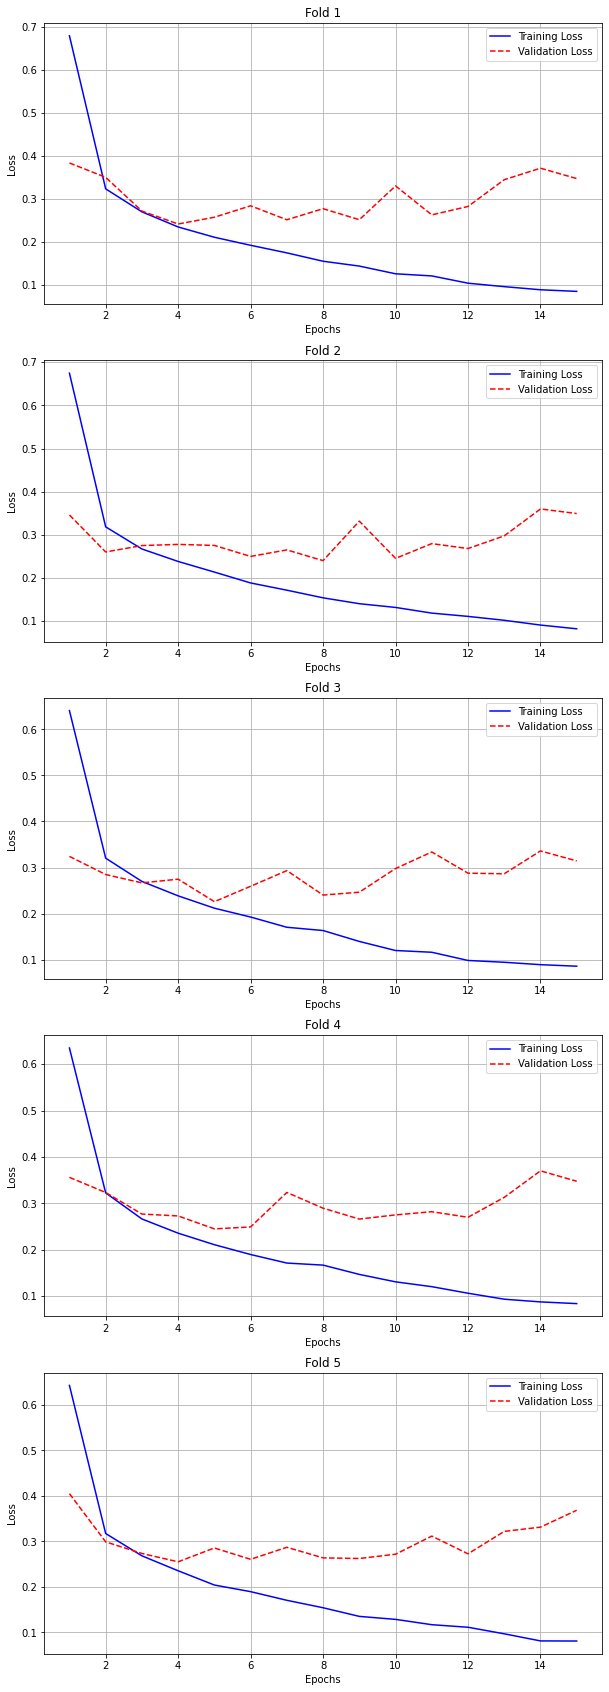

In [20]:
xAxis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

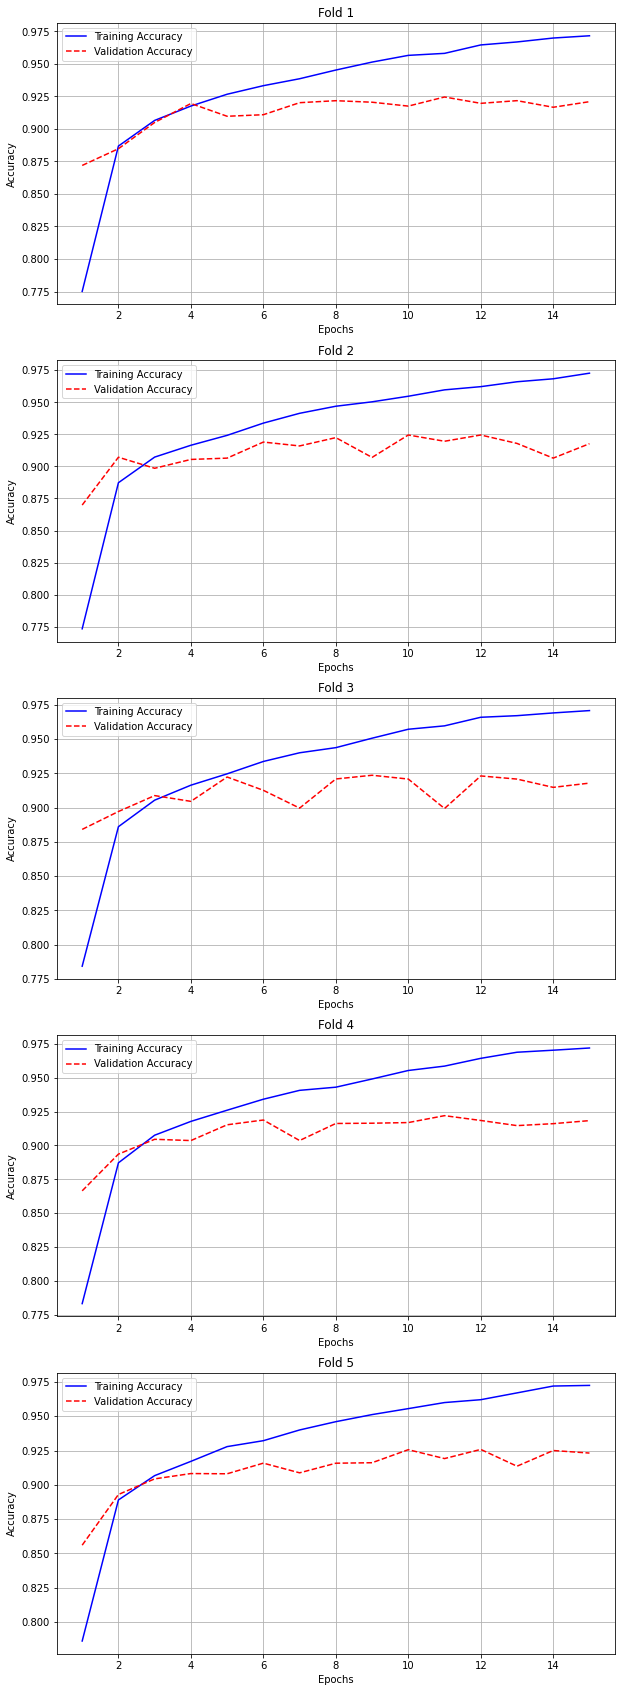

In [21]:
plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, AT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Accuracy")
    plt.plot(xAxis, AV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()